<a href="https://colab.research.google.com/github/xopherw/capstone-random-forrest/blob/main/California.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.inspection import permutation_importance
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np, pandas as pd, seaborn as sns

In [2]:
california_housing = "/content/drive/MyDrive/Colab Notebooks/Kaggle/california_housing.csv"
california_df = pd.read_csv(california_housing)

In [3]:
def pied_piper(df, y_value):
  pipe = Pipeline([("imputer", IterativeImputer()), ("scaler", StandardScaler()), ('normalizer', Normalizer())])
  sample = sampler(df)
  X = pipe.fit_transform(sample.drop([y_value], axis=1))
  y = np.log(sample[y_value])
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)
  return X_train, X_test, y_train, y_test


def sampler(df):
  return df.sample(n=15000, ignore_index=True, random_state=69)


def MAE_RMSE_list(reslist):
    # Initialize lists
    mlist = [[] for i in range(6)]
    for item in reslist:
        for i in range(0, len(item)):
            mlist[i].append(item[i])     
    for i in range(0, len(reslist[0])):
        mlist[i] = [item for items in mlist[i] for item in items]
    return mlist


def evaluate_models_results(model_pipe, X, y):
    # Evaluate the model and return results
    result1, result2 = list(), list()
    score1_mean, score1_std, score2_mean, score2_std = list(), list(), list(), list()
    score1 = cross_val_score(model_pipe, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
    score2 = cross_val_score(model_pipe, X, y, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
    score1 = np.absolute(score1)
    score2 = np.absolute(score2)
    # Store results
    result1.append(score1)
    result2.append(score2)
    score1_mean.append(np.mean(score1))
    score2_mean.append(np.mean(score2))
    score1_std.append(np.std(score1))
    score2_std.append(np.std(score2))
    return score1_mean, score1_std, score2_mean, score2_std, result1, result2

def feature_importances_plot(model, X, y):
  importances = permutation_importance(model, X, y, n_repeats=30, random_state=42)
  indices = importances.importances_mean.argsort()

  plt.title('Feature Importances')
  plt.barh(range(len(indices)), importances.importances_mean[indices], color='b', align='center')
  plt.yticks(range(len(indices)), [cols[i] for i in indices])
  plt.xlabel('Relative Importance')
  plt.show()
  

# **California Data**

In [4]:
california_df['median_house_value'] = california_df['median_house_value'].apply(lambda x: x*10000) # Transform total price

In [5]:
# sample_california = sampler(california_df)
cols = california_df.drop(['median_house_value'], axis=1).columns
evals =["algorithm","score", "MAE_mean", "MAE_std", "RMSE_mean", "RMSE_std", "MAE_result", "RMSE_result"]
evaluations = pd.DataFrame(columns=evals)

In [6]:
X_train, X_test, y_train, y_test = pied_piper(california_df, "median_house_value")

Random Forrest

In [7]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 66, criterion="absolute_error")

rf.fit(X_train, y_train)
score = rf.score(X_test, y_test)
print(score)

cross_list = list(evaluate_models_results(rf, X_test, y_test))
cross_list.insert(0, [score])
cross_list.insert(0, ["Random Forest"])
evaluations = evaluations.append(pd.DataFrame([[val for sublist in cross_list for val in sublist]], columns=evals))

0.7823159556560891


<ipython-input-7-d731a47b7b69>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluations = evaluations.append(pd.DataFrame([[val for sublist in cross_list for val in sublist]], columns=evals))


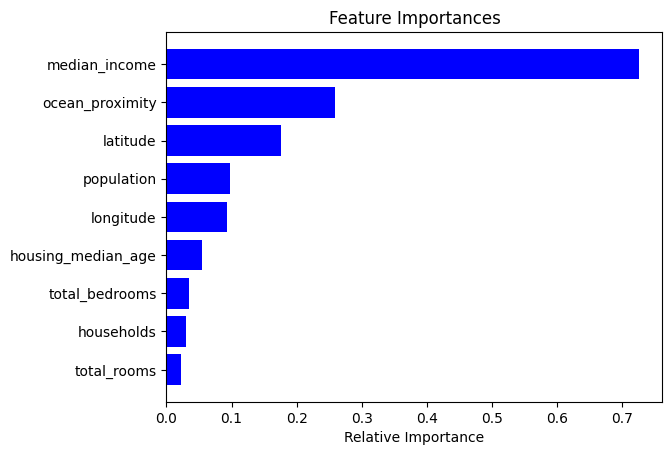

In [8]:
feature_importances_plot(rf, X_test, y_test)

K - Nearest Neighbor

In [9]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

knn.fit(X_train, y_train)
score = knn.score(X_test, y_test)
print(score)

cross_list = list(evaluate_models_results(knn, X_test, y_test))
cross_list.insert(0, [score])
cross_list.insert(0, ["KNN"])
evaluations = evaluations.append(pd.DataFrame([[val for sublist in cross_list for val in sublist]], columns=evals))

0.7599428558648692


<ipython-input-9-9310dc1f2843>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluations = evaluations.append(pd.DataFrame([[val for sublist in cross_list for val in sublist]], columns=evals))


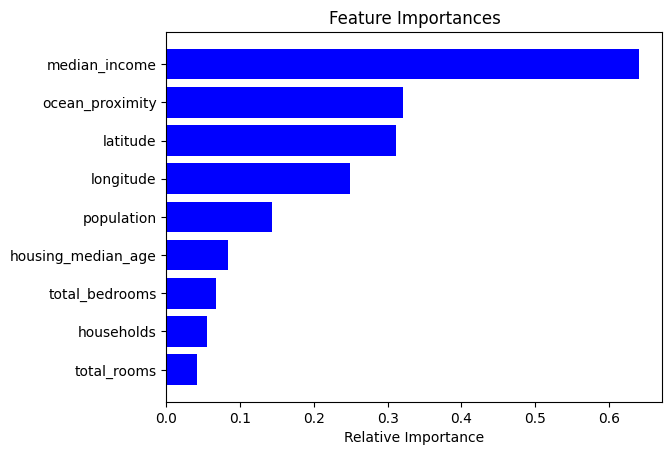

In [10]:
feature_importances_plot(knn, X_test, y_test)

Gradient Boost

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(criterion="squared_error", random_state=42)

gb.fit(X_train, y_train)
score = gb.score(X_test, y_test)
print(score)

cross_list = list(evaluate_models_results(gb, X_test, y_test))
cross_list.insert(0, [score])
cross_list.insert(0, ["Gradient Boost"])
evaluations = evaluations.append(pd.DataFrame([[val for sublist in cross_list for val in sublist]], columns=evals))

0.75412489107975


<ipython-input-11-669816ca8390>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluations = evaluations.append(pd.DataFrame([[val for sublist in cross_list for val in sublist]], columns=evals))


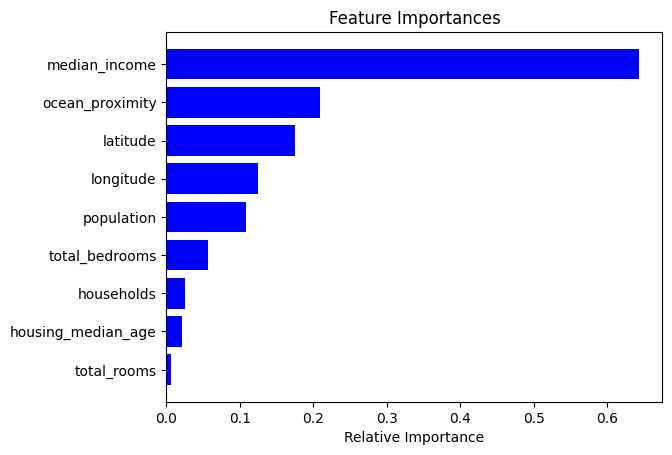

In [12]:
feature_importances_plot(gb, X_test, y_test)

SVR

In [13]:
from sklearn.svm import SVR

svr = SVR()

svr.fit(X_train, y_train)
score = svr.score(X_test, y_test)
print(score)

cross_list = list(evaluate_models_results(svr, X_test, y_test))
cross_list.insert(0, [score])
cross_list.insert(0, ["SVR"])
evaluations = evaluations.append(pd.DataFrame([[val for sublist in cross_list for val in sublist]], columns=evals))

0.809150800563301


<ipython-input-13-ad74211e6ecd>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluations = evaluations.append(pd.DataFrame([[val for sublist in cross_list for val in sublist]], columns=evals))


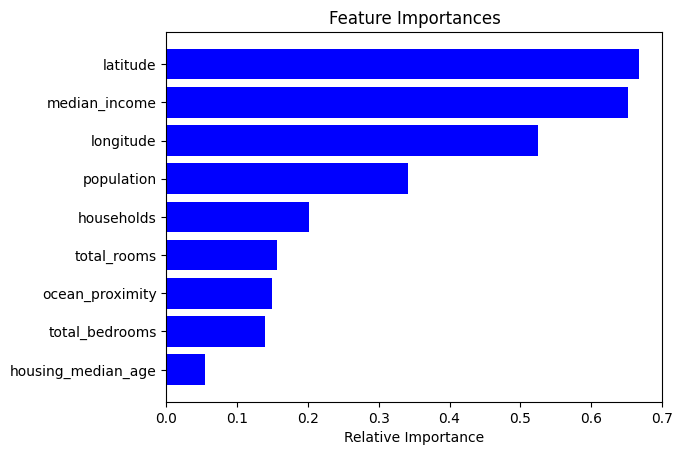

In [14]:
feature_importances_plot(svr, X_test, y_test)

Bayesian Linear Regression

In [15]:
from sklearn.linear_model import BayesianRidge

br = BayesianRidge(n_iter=150)

br.fit(X_train, y_train)
score = br.score(X_test, y_test)
print(score)

cross_list = list(evaluate_models_results(br, X_test, y_test))
cross_list.insert(0, [score])
cross_list.insert(0, ["BayeSian Ridge"])
evaluations = evaluations.append(pd.DataFrame([[val for sublist in cross_list for val in sublist]], columns=evals))

0.699804029869593


<ipython-input-15-4f7d4451996b>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluations = evaluations.append(pd.DataFrame([[val for sublist in cross_list for val in sublist]], columns=evals))


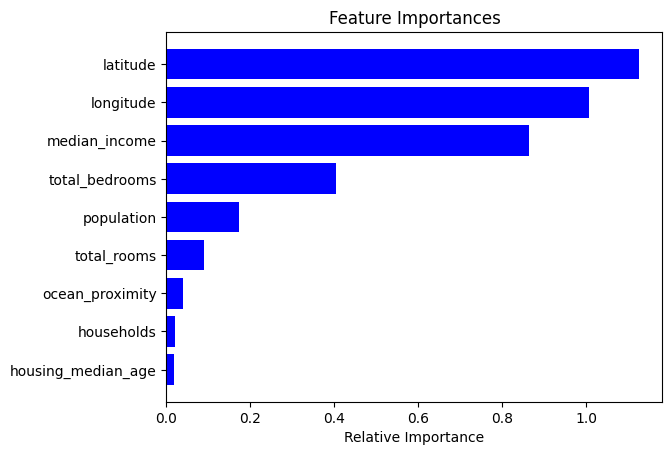

In [16]:
feature_importances_plot(br, X_test, y_test)

In [17]:
evaluations

,algorithm,score,MAE_mean,MAE_std,RMSE_mean,RMSE_std,MAE_result,RMSE_result
0,Random Forest,0.782316,0.219823,0.011441,0.292523,0.016976,"[0.22578991117851543, 0.21838767448216687, 0.2...","[0.3021578903066544, 0.2895374426337521, 0.280..."
0,KNN,0.759943,0.231287,0.010049,0.308708,0.017587,"[0.2419266694647673, 0.22641575261275093, 0.22...","[0.3242498289800176, 0.3052335321880213, 0.295..."
0,Gradient Boost,0.754125,0.223292,0.012531,0.295010,0.018655,"[0.2276064761635584, 0.21373678447456196, 0.21...","[0.298569357169252, 0.2870832207161713, 0.2799..."
0,SVR,0.809151,0.193521,0.008794,0.263146,0.017451,"[0.2010940493222848, 0.19109764162099846, 0.18...","[0.2735413304007979, 0.25841356260501447, 0.25..."
0,BayeSian Ridge,0.699804,0.239375,0.014156,0.312003,0.017336,"[0.24654402610973, 0.2375355182700225, 0.22804...","[0.32115251771789266, 0.31004534137611095, 0.3..."
